https://github.com/UKPLab/sentence-transformers/blob/master/examples/applications/image-search/Image_Search-multilingual.ipynb

# Multilingual Joint Image & Text Embeddings 

This example shows how [SentenceTransformers](https://www.sbert.net) can be used to map images and texts to the same vector space. 

As model, we use the [OpenAI CLIP Model](https://github.com/openai/CLIP), which was trained on a large set of images and image alt texts.

The original CLIP Model only works for English, hence, we used [Multilingual Knowlegde Distillation](https://arxiv.org/abs/2004.09813) to make this model work with 50+ languages.

As a source for fotos, we use the [Unsplash Dataset Lite](https://unsplash.com/data), which contains about 25k images. See the [License](https://unsplash.com/license) about the Unsplash images. 

Note: 25k images is rather small. If you search for really specific terms, the chance are high that no such photo exist in the collection.

In [8]:
from sentence_transformers import SentenceTransformer, util
from PIL import Image, ImageFile
import glob
import torch
import pickle
import zipfile
from IPython.display import display
from IPython.display import Image as IPImage
import os
from tqdm.autonotebook import tqdm

# Here we load the multilingual CLIP model. Note, this model can only encode text.
# If you need embeddings for images, you must load the 'clip-ViT-B-32' model
model = SentenceTransformer('clip-ViT-B-32-multilingual-v1')

In [9]:
# Next, we get about 25k images from Unsplash 
img_folder = 'photos/'
if not os.path.exists(img_folder) or len(os.listdir(img_folder)) == 0:
    os.makedirs(img_folder, exist_ok=True)
    
    photo_filename = 'unsplash-25k-photos.zip'
    if not os.path.exists(photo_filename):   #Download dataset if does not exist
        util.http_get('http://sbert.net/datasets/'+photo_filename, photo_filename)
        
    #Extract all images
    with zipfile.ZipFile(photo_filename, 'r') as zf:
        for member in tqdm(zf.infolist(), desc='Extracting'):
            zf.extract(member, img_folder)
        

In [10]:
# Now, we need to compute the embeddings
# To speed things up, we destribute pre-computed embeddings
# Otherwise you can also encode the images yourself.
# To encode an image, you can use the following code:
# from PIL import Image
# img_emb = model.encode(Image.open(filepath))

use_precomputed_embeddings = False

if use_precomputed_embeddings: 
    emb_filename = 'unsplash-25k-photos-embeddings.pkl'
    if not os.path.exists(emb_filename):   #Download dataset if does not exist
        util.http_get('http://sbert.net/datasets/'+emb_filename, emb_filename)
        
    with open(emb_filename, 'rb') as fIn:
        img_names, img_emb = pickle.load(fIn)  
    print("Images:", len(img_names))
else:
    #For embedding images, we need the non-multilingual CLIP model
    img_model = SentenceTransformer('clip-ViT-B-32')

    img_names = list(glob.glob('photos/*.jpg'))
    print("Images:", len(img_names))

    #img_emb = img_model.encode([Image.open(filepath) for filepath in img_names], batch_size=32, convert_to_tensor=True, show_progress_bar=True) # OSError: [Errno 24] Too many open files
    img_embs = []
    for i in range(len(img_names)):
        print(i,end='\r')
        img_emb = img_model.encode(Image.open(img_names[i]), convert_to_tensor=True)
        img_embs.append(img_emb)


ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


Images: 24996


In [17]:
# Next, we define a search function.
def search(query, k=3):
    # First, we encode the query (which can either be an image or a text string)
    query_emb = model.encode([query], convert_to_tensor=True, show_progress_bar=False)
    
    # Then, we use the util.semantic_search function, which computes the cosine-similarity
    # between the query embedding and all image embeddings.
    # It then returns the top_k highest ranked images, which we output
    hits = util.semantic_search(query_emb, img_embs, top_k=k)[0]
    
    print("Query:")
    display(query)
    for hit in hits:
        print(img_names[hit['corpus_id']])
        display(IPImage((img_names[hit['corpus_id']]), width=200))


Query:


'Two dogs playing in the snow'

photos\lyStEjlKNSw.jpg


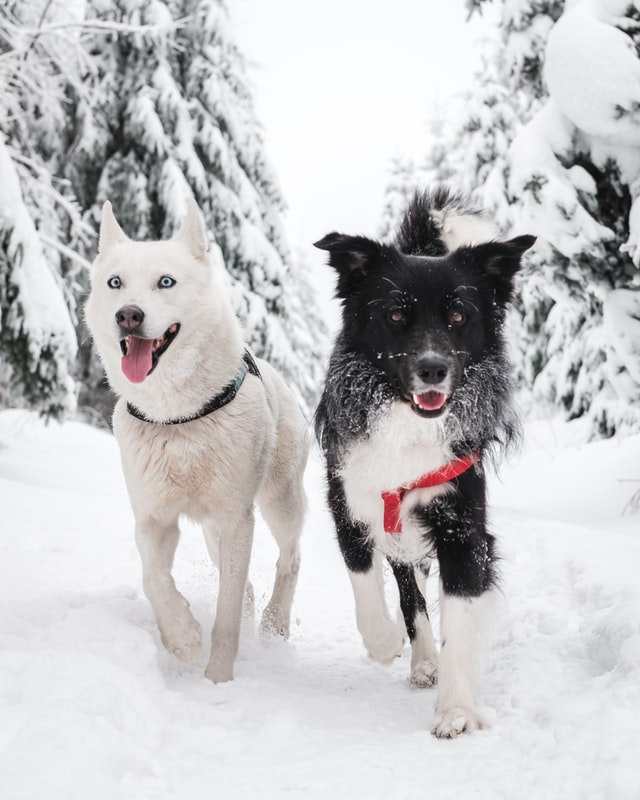

photos\FAcSe7SjDUU.jpg


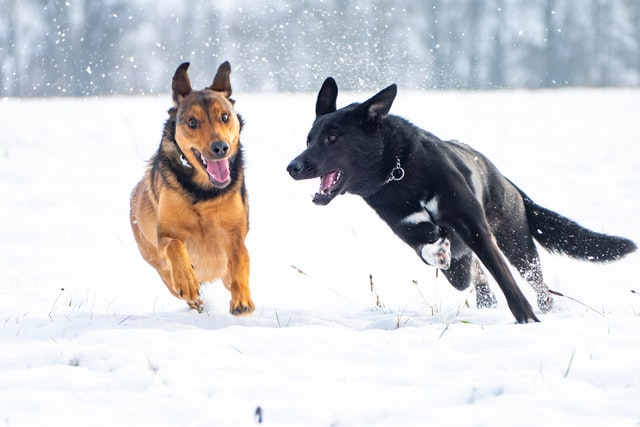

photos\Hb6nGDgWztE.jpg


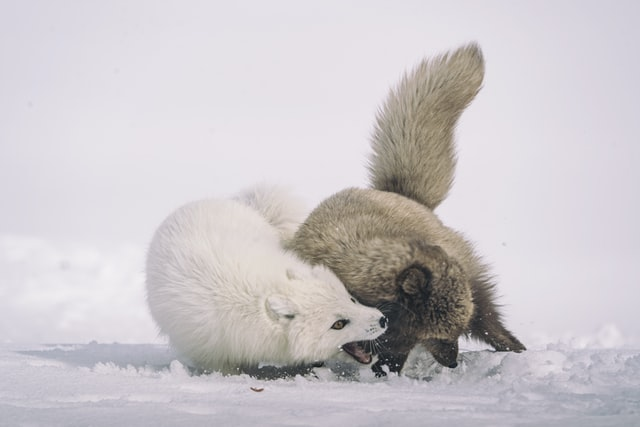

In [18]:
search("Two dogs playing in the snow")

Query:


'Eine Katze auf einem Stuhl'

photos\CgGDzMYdYw8.jpg


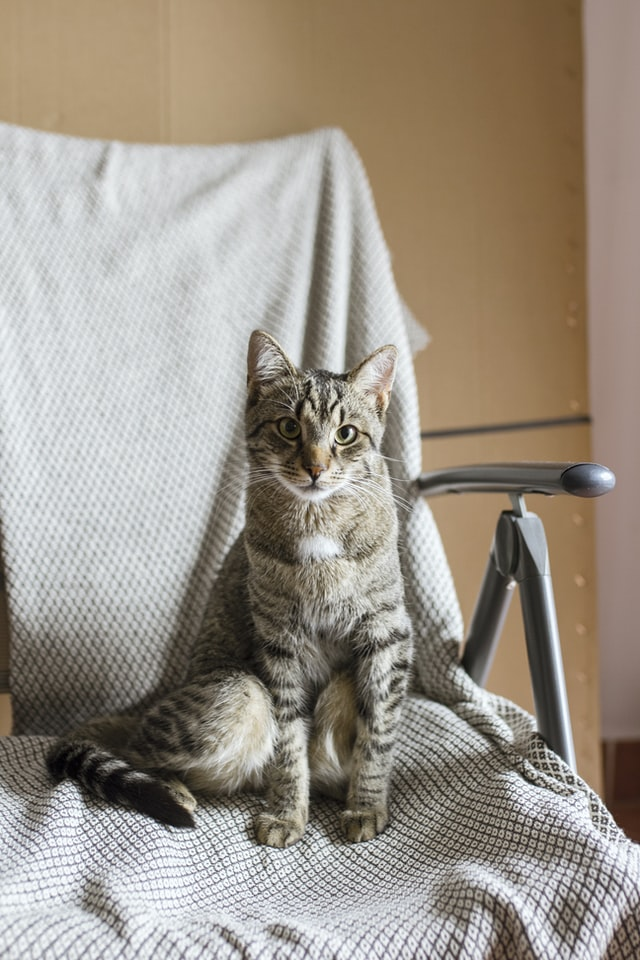

photos\kjERLXaHjXc.jpg


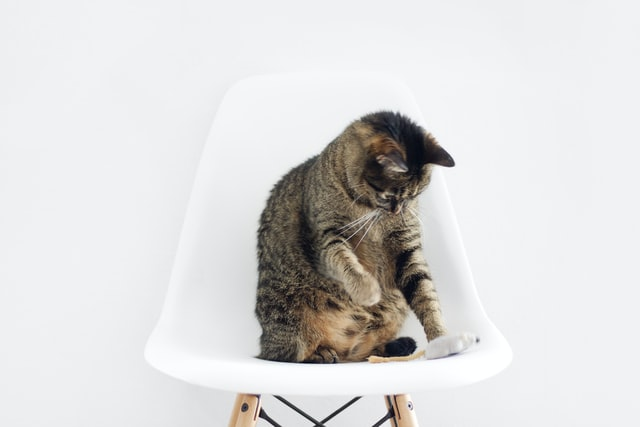

photos\I-YJ-gaJNaw.jpg


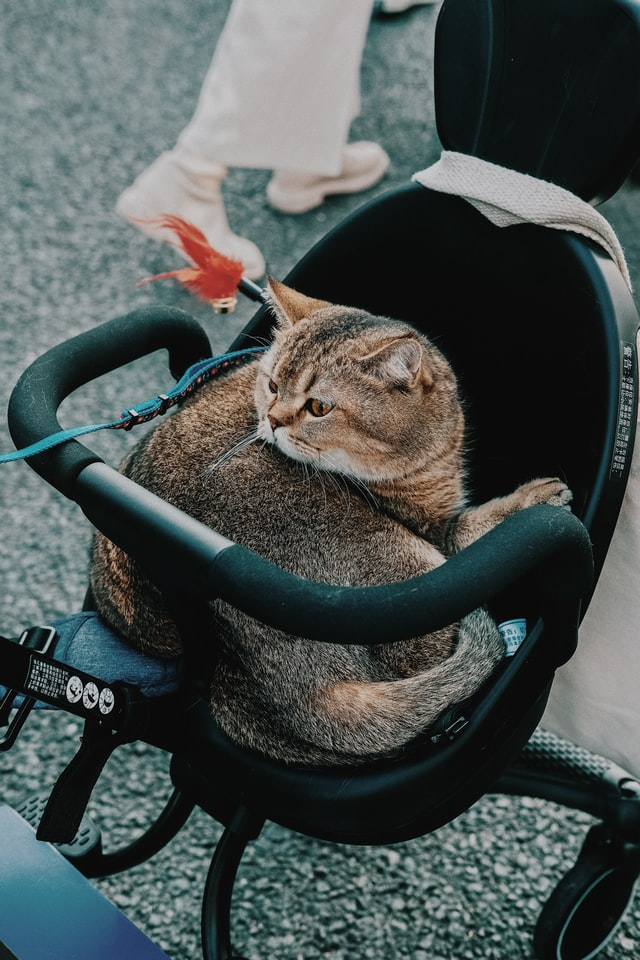

In [19]:
#German: A cat on a chair
search("Eine Katze auf einem Stuhl")

Query:


'Muchos peces'

photos\H22jcGTyrS4.jpg


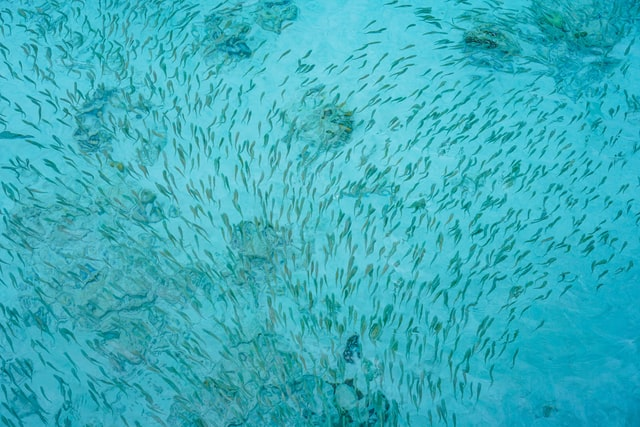

photos\IXZru8ftAy0.jpg


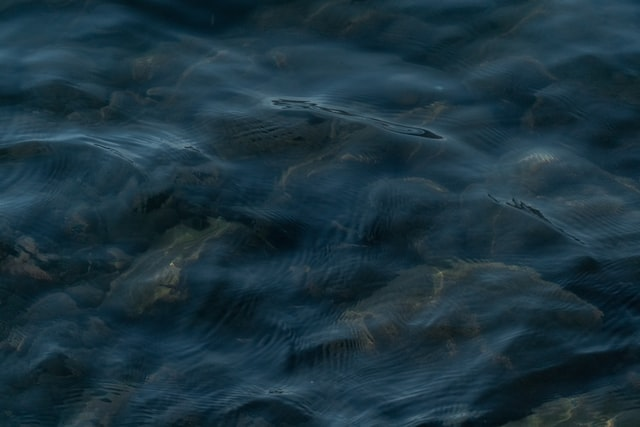

photos\wfXF5aAdvS0.jpg


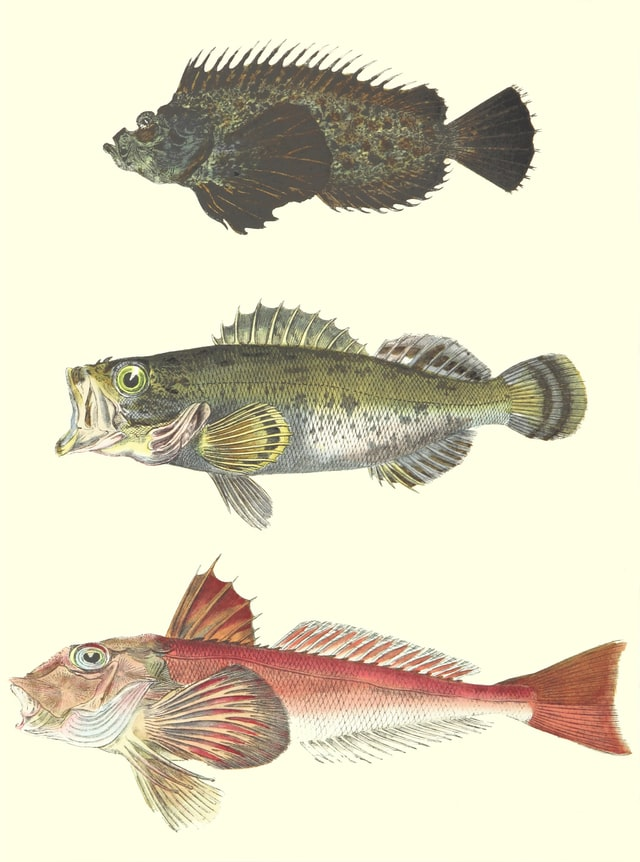

In [20]:
#Spanish: Many fish
search("Muchos peces")

Query:


'棕榈树的沙滩'

photos\crIXKhUDpBI.jpg


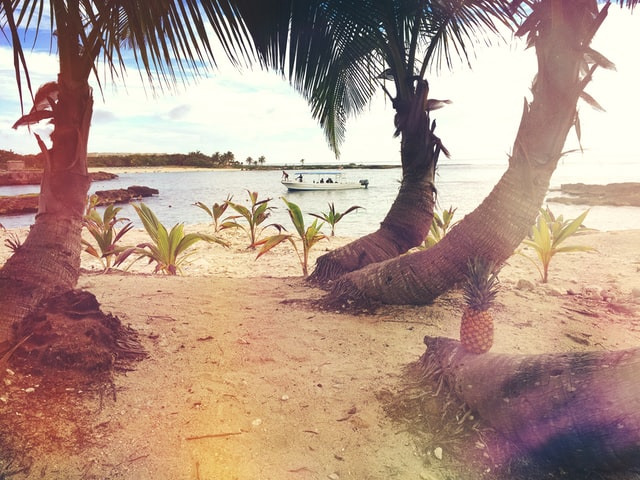

photos\_6iV1AJZ53s.jpg


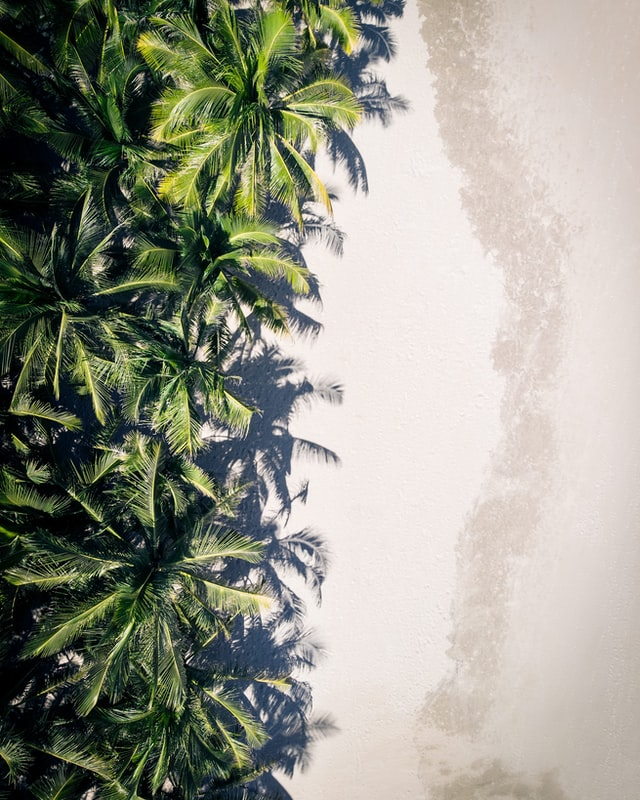

photos\rv63du1a79E.jpg


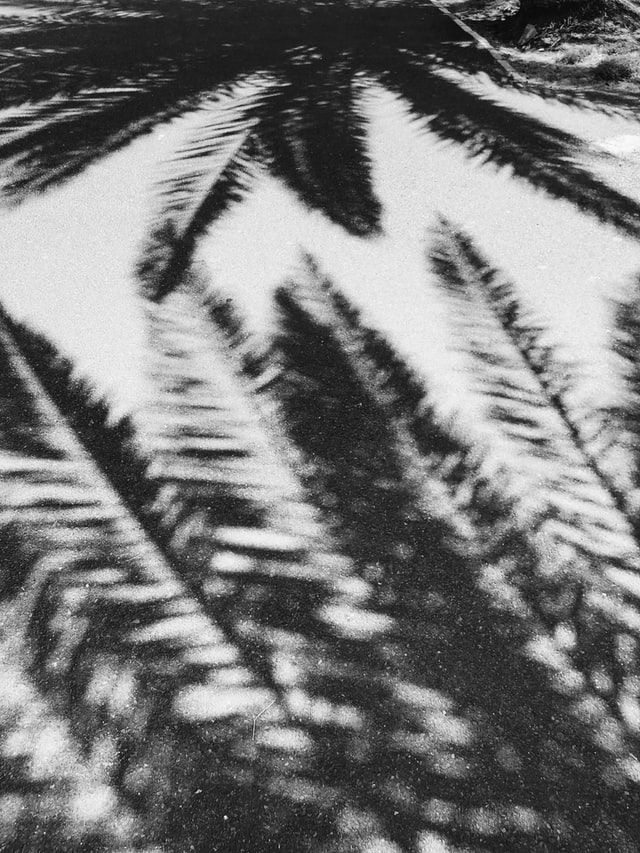

In [21]:
#Chinese: A beach with palm trees
search("棕榈树的沙滩")

Query:


'Закат на пляже'

photos\JC5U3Eyiyr4.jpg


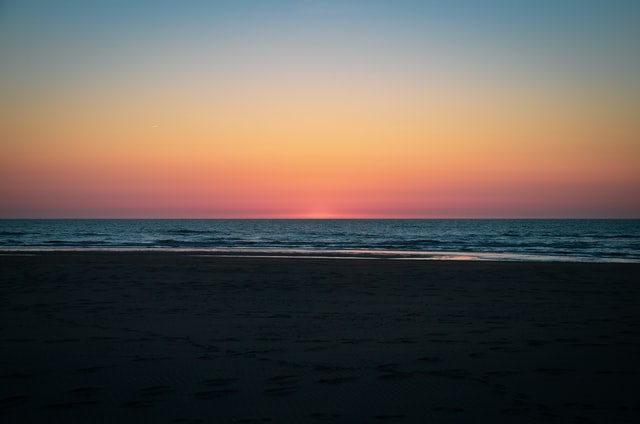

photos\5z1QDcisnJ8.jpg


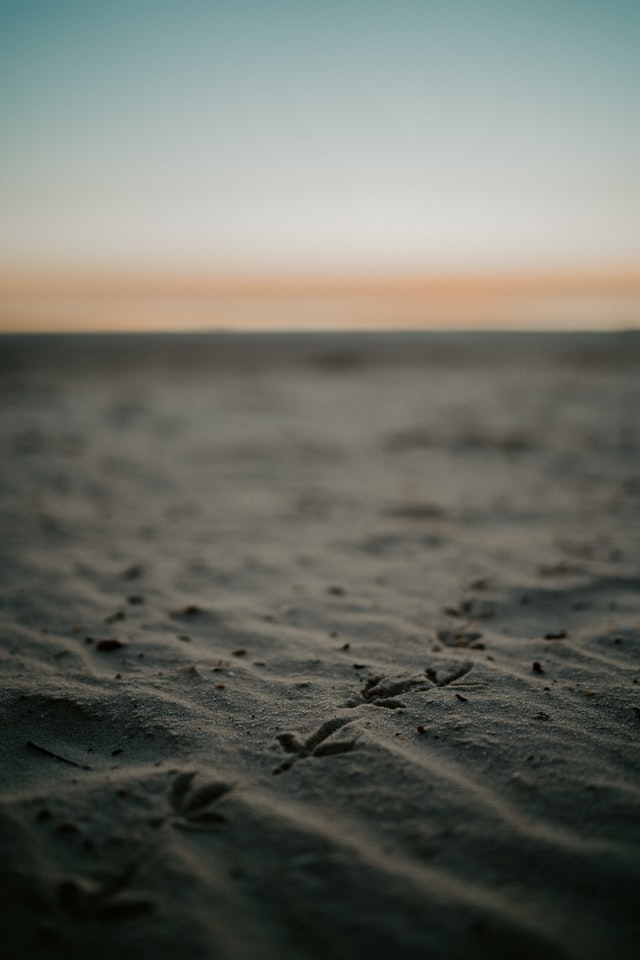

photos\rdG4hRoyVR0.jpg


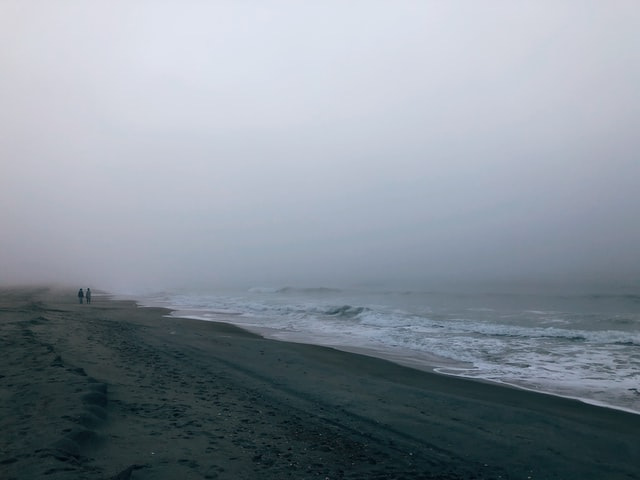

In [22]:
#Russian: A sunset on the beach
search("Закат на пляже")

Query:


'Parkta bir köpek'

photos\4mdsPUtN0P0.jpg


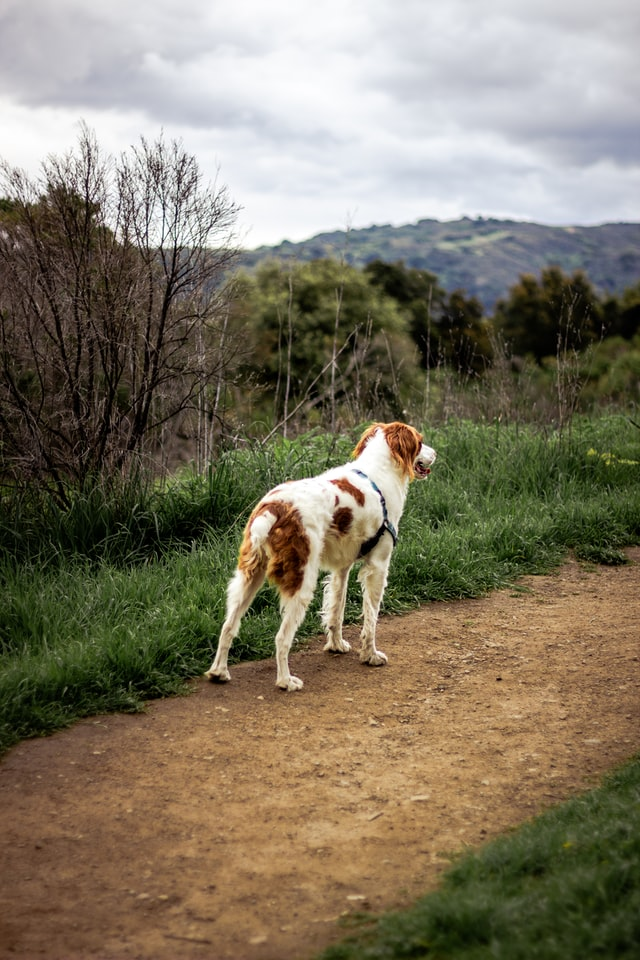

photos\ROJLfAbL1Ig.jpg


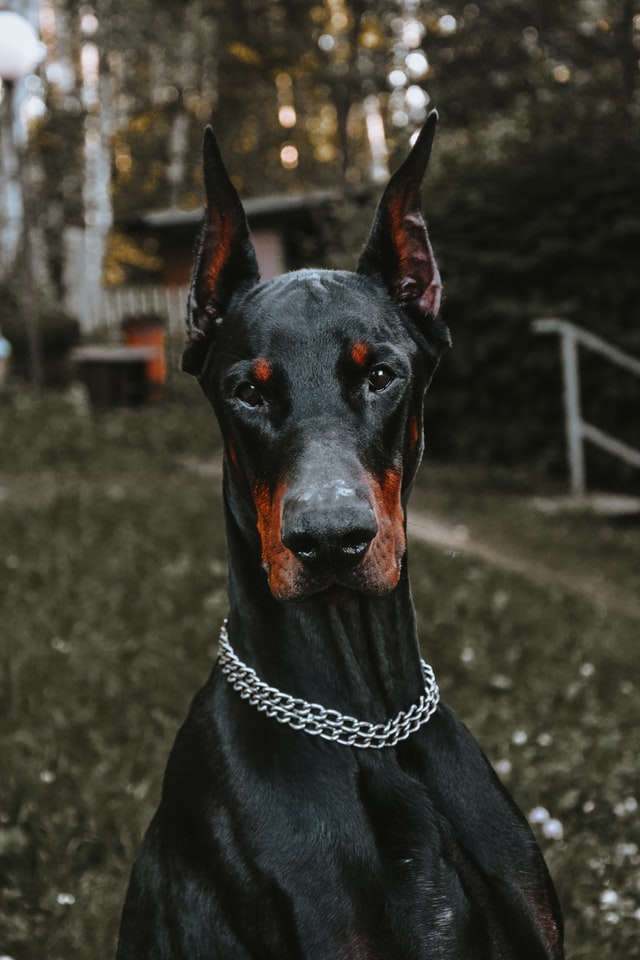

photos\xuqp36-VuDM.jpg


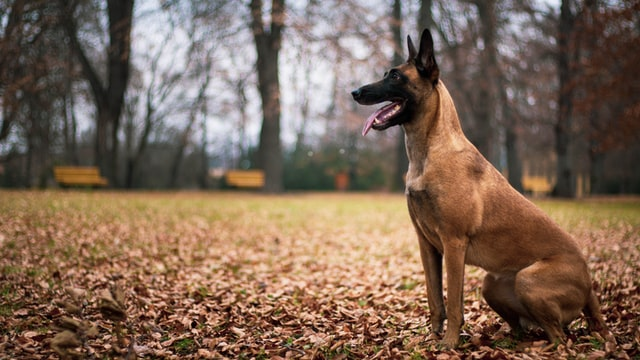

In [23]:
#Turkish: A dog in a park
search("Parkta bir köpek")

Query:


'夜のニューヨーク'

photos\8nCMOFYyXF4.jpg


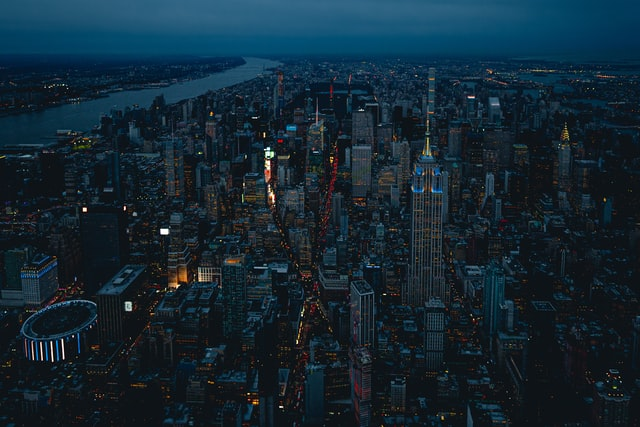

photos\FGjR4IGwP7U.jpg


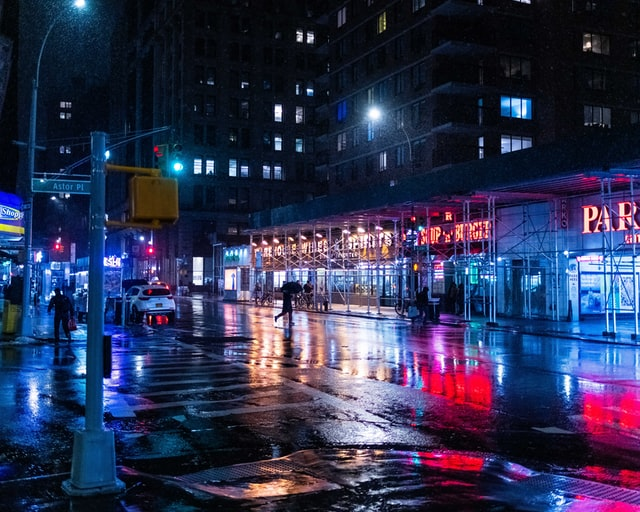

photos\ZAOEjcpdMkc.jpg


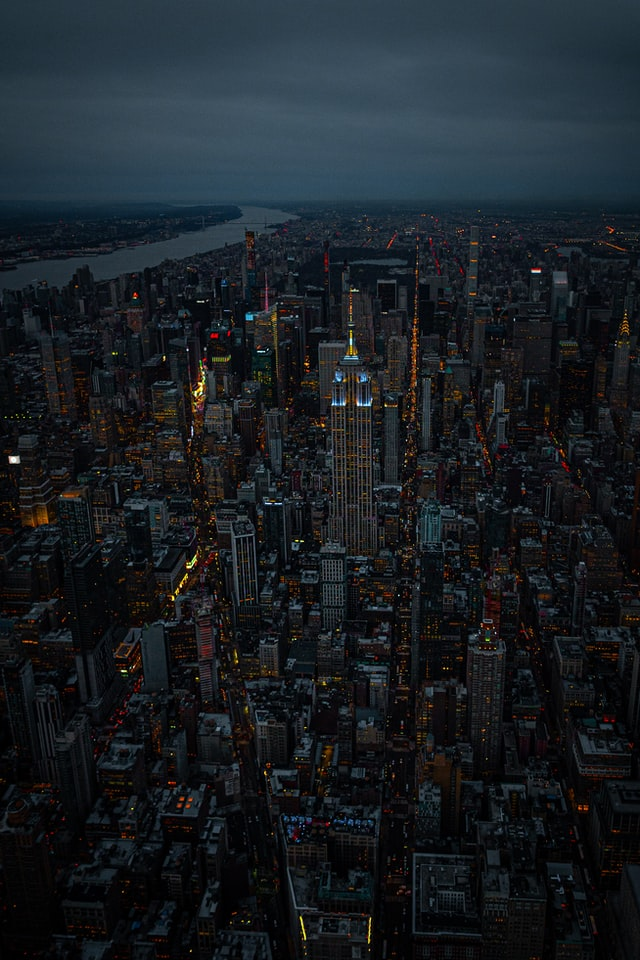

In [24]:
# Japanese: New York at night
search("夜のニューヨーク")

Query:


'Ló'

photos\XlxJUmDNKcE.jpg


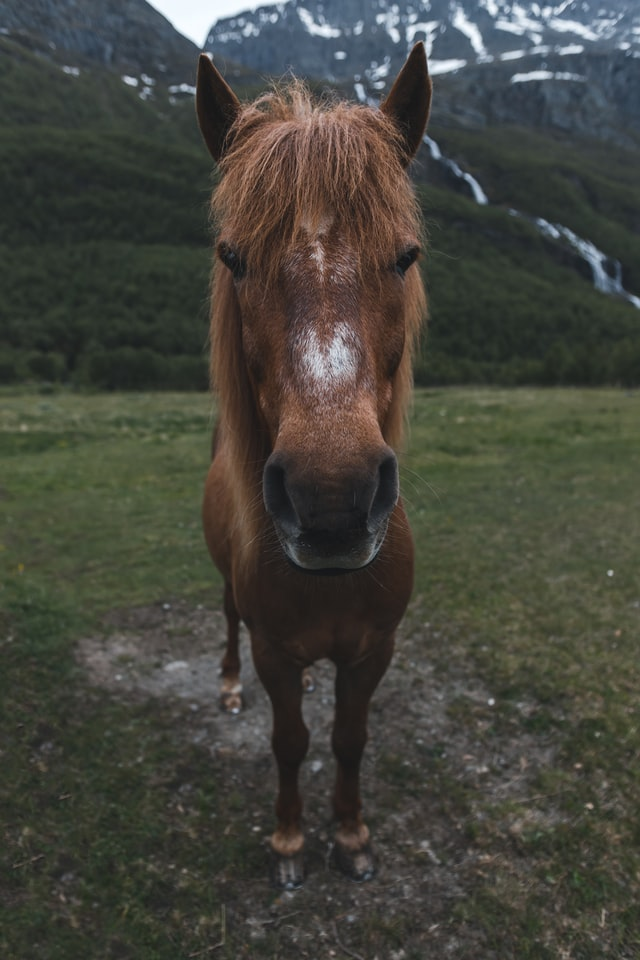

photos\YAzmlr2kjSY.jpg


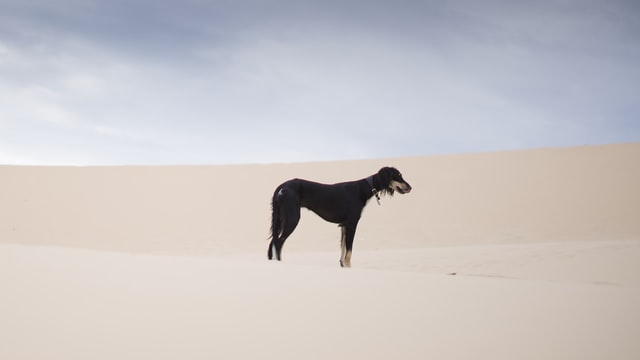

photos\cyUo1MGv-4I.jpg


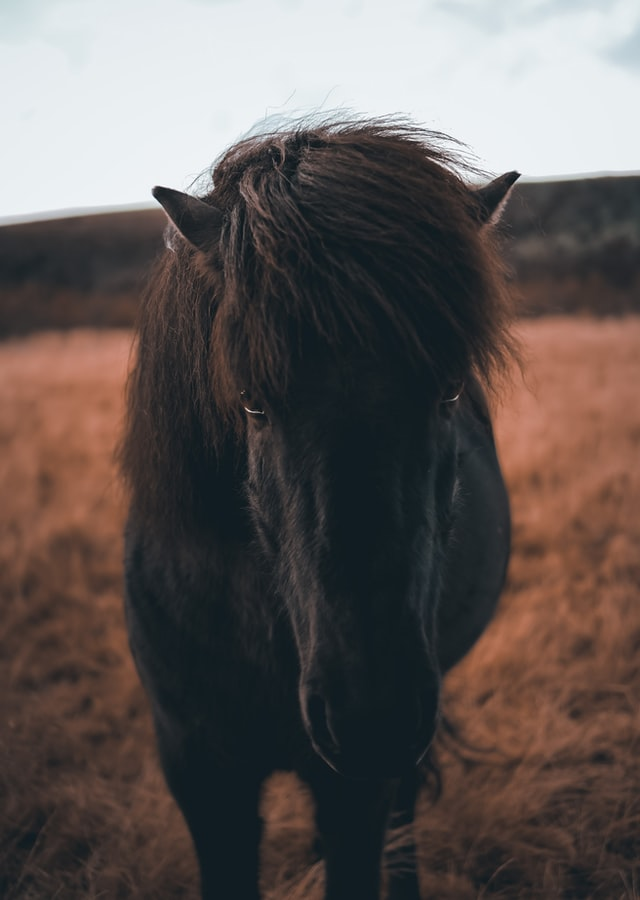

In [30]:
search("Ló")